In [76]:
%matplotlib inline
from pathlib import Path

import numpy as np
from numpy.random import choice
from numpy.linalg import norm
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist

from sklearn.preprocessing import minmax_scale
from sklearn.manifold import TSNE

from scipy.spatial.distance import pdist, cdist

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [77]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

sns.set_style('whitegrid')

n_classes = 10 # all examples have 10 classes
cmap = sns.color_palette('Paired', n_classes)
results_path = Path('results', 'fashion_mnist')
if not results_path.exists():
    results_path.mkdir(parents=True)

Using GPU


In [78]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [79]:
image_size = 28     # size of image (pixels per side)
# Compression factor: 784 / 32 = 24.5
input_size = image_size ** 2 # for a flat 1 dimensional pixel vector
class_dict = {0: 'T-shirt/top',
              1: 'Trouser',
              2: 'Pullover',
              3: 'Dress',
              4: 'Coat',
              5: 'Sandal',
              6: 'Shirt',
              7: 'Sneaker',
              8: 'Bag',
              9: 'Ankle boot'}
classes = list(class_dict.keys())

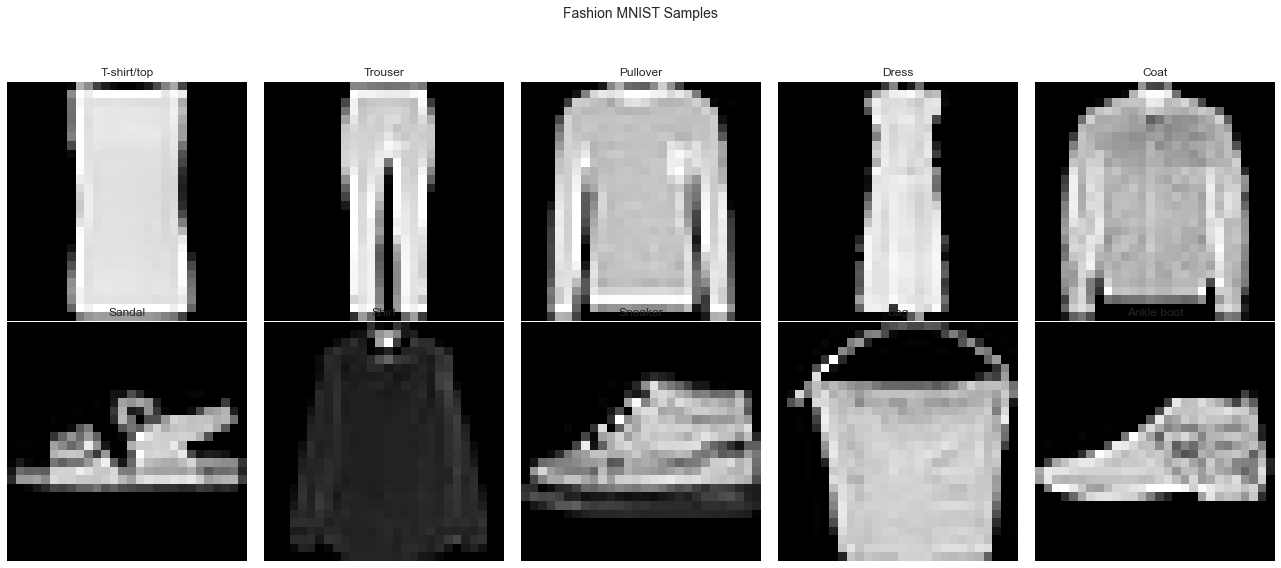

In [80]:
# Plot sample images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 8))
axes =axes.flatten()
for row, label in enumerate(classes):
    label_idx = np.argwhere(y_train == label).squeeze()
    axes[row].imshow(X_train[choice(label_idx)], cmap='gray')
    axes[row].axis('off')
    axes[row].set_title(class_dict[row])

fig.suptitle('Fashion MNIST Samples', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85)

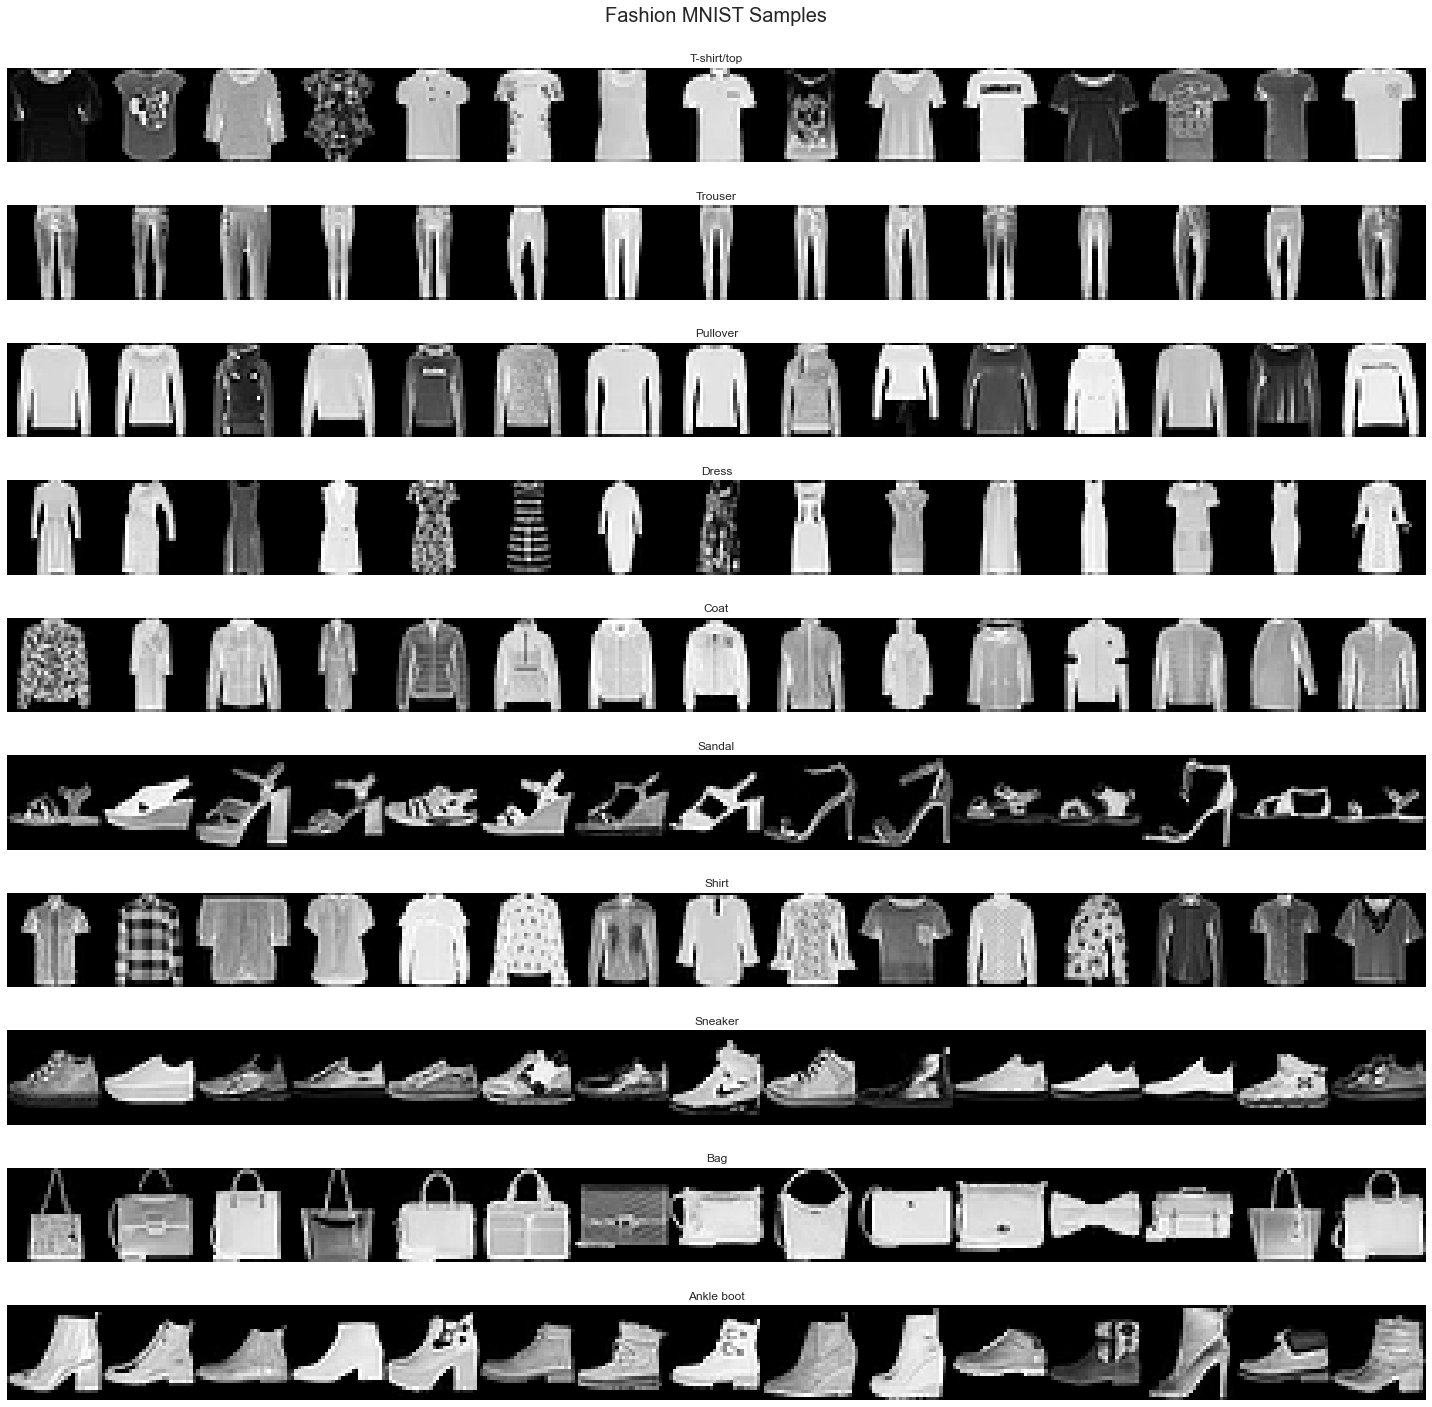

In [81]:
n_samples = 15
fig, axes = plt.subplots(nrows=n_classes, figsize=(20, 20))
axes = axes.flatten() # from 2 dimensional numpy array to 1 dimensional numpy array

for row, label in enumerate(classes):
    class_imgs = np.empty(shape=(image_size, n_samples * image_size))
    label_idx = np.argwhere(y_train == label).squeeze()
    class_samples = choice(label_idx, size=n_samples, replace=False)
    for col, sample in enumerate(class_samples):
        i = col * image_size
        class_imgs[:, i:i + image_size] = X_train[sample]
    axes[row].imshow(class_imgs, cmap='gray')
    axes[row].axis('off')
    axes[row].set_title(class_dict[row])

fig.suptitle('Fashion MNIST Samples', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.95, bottom=0)

In [82]:
# Reshape & normalize[0, 1] Fashion MNIST data
encoding_size = 32 # Size of encoding

def data_prep(x, size=input_size):
    return x.reshape(-1, size).astype('float32')/255

X_train_scaled = data_prep(X_train)
X_test_scaled = data_prep(X_test)
X_train_scaled.shape, X_test_scaled.shape

((60000, 784), (10000, 784))

In [83]:
# Vanilla single-layer autoencoder
input_ = Input(shape=(input_size,), name='Input')
encoding = Dense(units=encoding_size, activation='relu', name='Encoder')(input_)
decoding = Dense(units=input_size, activation='sigmoid', name='Decoder')(encoding)

In [84]:
autoencoder = Model(inputs=input_, outputs=decoding, name='Autoencoder')
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 Encoder (Dense)             (None, 32)                25120     
                                                                 
 Decoder (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [85]:
encoder = Model(inputs=input_ , outputs=encoding, name='Encoder')
encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 Encoder (Dense)             (None, 32)                25120     
                                                                 
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [86]:
# Decoder Model
encoded_input = Input(shape=(encoding_size,), name='Decoder_Input')
decoder_layer = autoencoder.layers[-1](encoded_input)

In [87]:
decoder = Model(inputs=encoded_input, outputs=decoder_layer)
decoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Decoder_Input (InputLayer)  [(None, 32)]              0         
                                                                 
 Decoder (Dense)             (None, 784)               25872     
                                                                 
Total params: 25,872
Trainable params: 25,872
Non-trainable params: 0
_________________________________________________________________


In [88]:
autoencoder.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=0,
                               restore_best_weights=True, mode='auto')
tb_callback = TensorBoard(log_dir=results_path / 'logs', histogram_freq=5, write_graph=True, write_images=True)

In [89]:
filepath = (results_path / 'autencoder.32.weights.hdf5').as_posix()

In [90]:
checkpointer = ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True,
                               save_weights_only=True, mode='auto')
training = autoencoder.fit(x=X_train_scaled, y=X_train_scaled, epochs=100, batch_size=32, shuffle=True,
                           validation_split=.1, callbacks=[tb_callback, early_stopping, checkpointer])

Epoch 1/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0298 - val_loss: 0.0176
Epoch 2/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0153 - val_loss: 0.0141
Epoch 3/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0136 - val_loss: 0.0135
Epoch 4/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0132 - val_loss: 0.0131
Epoch 5/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0130 - val_loss: 0.0130
Epoch 6/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 7/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 8/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0127 - val_loss: 0.0131
Epoch 9/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0127 - val_loss: 0.0128
Epoch 10/100
1688/1688 [==============================] - 3s 2ms/step - l

In [91]:
# Loads all layer weights
autoencoder.load_weights(filepath)

In [92]:
mse = autoencoder.evaluate(x=X_test_scaled, y=X_test_scaled)
print(f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}')

313/313 [==============================] - 0s 1ms/step - loss: 0.0125
MSE: 0.0125 | RMSE 0.1119


In [93]:
encoded_test_img = encoder.predict(X_test_scaled) # as decoder's input parameters
encoded_test_img.shape

(10000, 32)

In [94]:
encoded_test_img[:5]

array([[ 1.7760373 ,  2.835462  ,  3.9431398 ,  0.97978824,  3.9782288 ,
         5.6960526 ,  3.2259083 ,  2.551232  ,  3.5710266 ,  3.7785273 ,
         2.6440072 ,  3.05766   ,  4.742099  ,  4.383618  ,  1.6105285 ,
         0.        ,  6.188278  ,  2.0087292 ,  2.5978014 ,  2.9209473 ,
         1.7181458 ,  3.018876  ,  0.68700063,  5.7120395 ,  8.494777  ,
         4.5224423 ,  2.3113618 ,  3.655778  ,  0.9965143 ,  2.0113533 ,
         0.07382318,  3.7197993 ],
       [ 8.40075   ,  5.759815  ,  0.87165916,  4.892814  ,  6.0487566 ,
         7.457831  ,  3.4202206 ,  3.6952925 ,  2.0086737 ,  0.40597916,
         5.6261964 ,  2.8741388 ,  1.5774941 ,  0.        ,  9.0604515 ,
         4.595869  ,  1.6110785 ,  4.6974196 ,  0.        ,  8.71784   ,
         3.0298486 ,  1.6629151 , 11.35951   ,  4.027191  ,  6.56452   ,
         4.075576  ,  1.4449351 ,  2.563872  ,  2.0067277 ,  2.1953459 ,
         4.156     , 10.104981  ],
       [ 0.6138469 ,  6.320122  ,  6.4635835 ,  7.6414

In [95]:
decoded_test_img = decoder.predict(encoded_test_img)
decoded_test_img.shape

(10000, 784)

In [96]:
decoded_test_img[:5]

array([[3.2517726e-09, 2.8451543e-09, 7.6462362e-07, ..., 2.2605428e-04,
        1.4483972e-04, 4.6245223e-06],
       [1.7676496e-11, 1.3083447e-11, 1.6805198e-09, ..., 7.4755950e-03,
        1.7098064e-05, 6.0784728e-09],
       [8.4379718e-11, 1.7338049e-10, 6.4604529e-07, ..., 6.3499904e-08,
        8.7521590e-07, 1.2763930e-06],
       [3.5919638e-09, 5.3962403e-09, 2.6854398e-06, ..., 2.6996911e-06,
        2.1497096e-06, 2.3188279e-06],
       [2.6885498e-08, 4.6654204e-08, 3.1165389e-06, ..., 1.5239278e-03,
        8.1614613e-05, 1.1331835e-05]], dtype=float32)

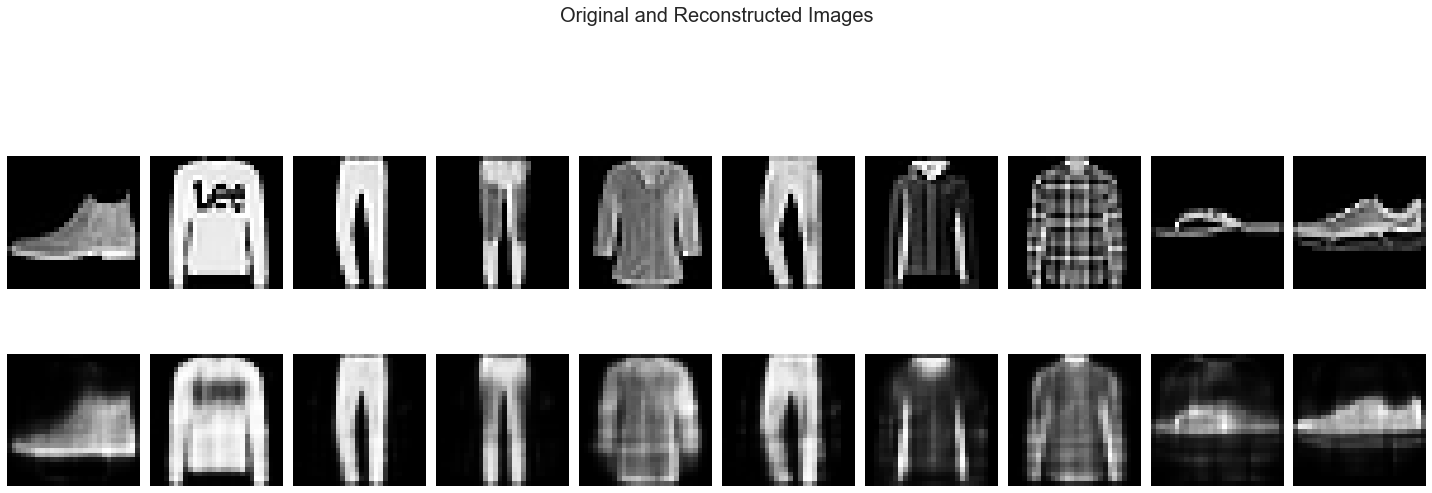

In [97]:
# Compare Original with Reconstructed Samples
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 8))

for i in range(n_classes):
    axes[0, i].imshow(X_test_scaled[i].reshape(image_size, image_size), cmap='gray') # original img
    axes[0, i].axis('off')
    axes[1, i].imshow(decoded_test_img[i].reshape(28, 28) , cmap='gray') # reconstructed img by autoencoder
    axes[1, i].axis('off')

fig.suptitle('Original and Reconstructed Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig(results_path / 'reconstructed', dpi=300)

In [98]:
# Combine training steps into function
def train_autoencoder(path, model, x_train=X_train_scaled, x_test=X_test_scaled):
    callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
                 ModelCheckpoint(filepath=path, save_best_only=True, save_weights_only=True)]
    model.fit(x=x_train, y=x_train, epochs=100, validation_split=.1, callbacks=callbacks)
    model.load_weights(path)
    mse = model.evaluate(x=x_test, y=x_test)
    return model, mse

In [99]:
# Autoencoders with Sparsity Constraints
encoding_l1 = Dense(units=encoding_size, activation='relu', activity_regularizer=regularizers.l1(10e-5),
                    name='Encoder_L1')(input_)
decoding_l1 = Dense(units=input_size, activation='sigmoid', name='Decoder_L1')(encoding_l1)
autoencoder_l1 = Model(input_, decoding_l1)
autoencoder_l1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 Encoder_L1 (Dense)          (None, 32)                25120     
                                                                 
 Decoder_L1 (Dense)          (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [100]:
autoencoder_l1.compile(optimizer='adam', loss='mse')

In [101]:
# Encoder & Decoder Models
encoder_l1 = Model(inputs=input_, outputs=encoding_l1, name='Encoder')
encoded_input = Input(shape=(encoding_size,), name='Decoder_Input')
decoder_l1_layer = autoencoder_l1.layers[-1](encoded_input)
decoder_l1 = Model(inputs=encoded_input, outputs=decoder_l1_layer)

In [102]:
autoencoder_l1.layers

In [103]:
path = (results_path / 'autencoder_l1.32.weights.hdf5').as_posix()
autoencoder_l1, mse = train_autoencoder(path, autoencoder_l1)

Epoch 1/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0345 - val_loss: 0.0221
Epoch 2/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0198 - val_loss: 0.0185
Epoch 3/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0177 - val_loss: 0.0173
Epoch 4/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0168 - val_loss: 0.0168
Epoch 5/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0163 - val_loss: 0.0163
Epoch 6/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 7/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0157 - val_loss: 0.0159
Epoch 8/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0155 - val_loss: 0.0157
Epoch 9/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 10/100
1688/1688 [==============================] - 3s 2ms/step - l

MSE: 0.0144 | RMSE 0.1199


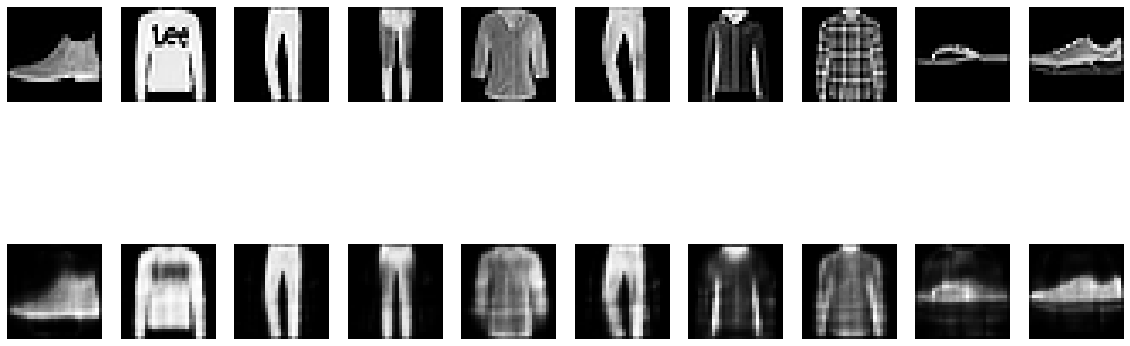

In [104]:
# Evaluate Model
print(f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}')

encoded_test_img = encoder_l1.predict(X_test_scaled)
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 8))
for i in range(n_classes):
    axes[0, i].imshow(X_test_scaled[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(decoded_test_img[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

In [105]:
# Deep Autoencoder

# Define three-layer architecture
input_ = Input(shape=(input_size,)) # 784
x = Dense(128, activation='relu', name='Encoding1')(input_) # 128
x = Dense(64, activation='relu', name='Encoding2')(x) # 64
encoding_deep = Dense(32, activation='relu', name='Encoding3')(x) # 32

x = Dense(64, activation='relu', name='Decoding1')(encoding_deep) # 64
x = Dense(128, activation='relu', name='Decoding2')(x) # 128
decoding_deep = Dense(input_size, activation='sigmoid', name='Decoding3')(x) # 784
autoencoder_deep = Model(input_, decoding_deep)
autoencoder_deep.compile(optimizer='adam', loss='mse')

In [106]:
autoencoder_deep.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 Encoding1 (Dense)           (None, 128)               100480    
                                                                 
 Encoding2 (Dense)           (None, 64)                8256      
                                                                 
 Encoding3 (Dense)           (None, 32)                2080      
                                                                 
 Decoding1 (Dense)           (None, 64)                2112      
                                                                 
 Decoding2 (Dense)           (None, 128)               8320      
                                                                 
 Decoding3 (Dense)           (None, 784)               1011

In [107]:
# Encoder & Decoder Models
encoder_deep = Model(inputs=input_, outputs=encoding_deep, name='Encoder')
encoded_input = Input(shape=(encoding_size,), name='Decoder_Input')

x = autoencoder_deep.layers[-3](encoded_input)
x = autoencoder_deep.layers[-2](x)
decoded = autoencoder_deep.layers[-1](x)

decoder_deep = Model(inputs=encoded_input, outputs=decoded)
decoder_deep.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Decoder_Input (InputLayer)  [(None, 32)]              0         
                                                                 
 Decoding1 (Dense)           (None, 64)                2112      
                                                                 
 Decoding2 (Dense)           (None, 128)               8320      
                                                                 
 Decoding3 (Dense)           (None, 784)               101136    
                                                                 
Total params: 111,568
Trainable params: 111,568
Non-trainable params: 0
_________________________________________________________________


In [108]:
# Train Model
path = (results_path  / 'autencoder_deep.32.weights.hdf5').as_posix()
autoencoder_deep, mse = train_autoencoder(path, autoencoder_deep)

Epoch 1/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0265 - val_loss: 0.0186
Epoch 2/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0170 - val_loss: 0.0161
Epoch 3/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0151 - val_loss: 0.0148
Epoch 4/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0140 - val_loss: 0.0139
Epoch 5/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0133 - val_loss: 0.0132
Epoch 6/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 7/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0124 - val_loss: 0.0125
Epoch 8/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0120 - val_loss: 0.0121
Epoch 9/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 10/100
1688/1688 [==============================] - 4s 2ms/step - l

In [109]:
autoencoder_deep.load_weights(path)

In [110]:
# Evaluate Model
print(f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}')

reconstructed_images = autoencoder_deep.predict(X_test_scaled)
reconstructed_images.shape

MSE: 0.0097 | RMSE 0.0987


(10000, 784)

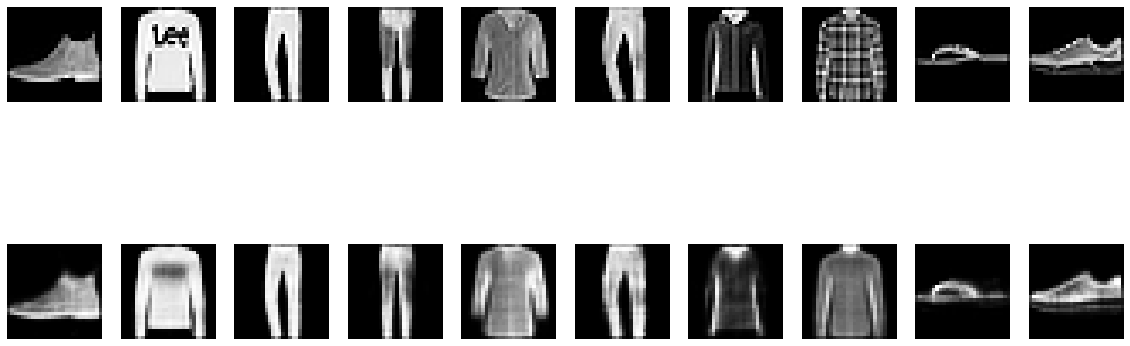

In [111]:
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 8))
for i in range(n_classes):
    axes[0, i].imshow(X_test_scaled[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_images[i].reshape(image_size, image_size) , cmap='gray')
    axes[1, i].axis('off')

In [112]:
# Compute t-SNE( t-distributed Stochastic Neighbor Embedding)

# alternatively, compute the result yourself
tsne = TSNE(perplexity=25, n_iter=5000) # # of nearest neighbors of the manifold learning
train_embed = tsne.fit_transform(encoder_deep.predict(X_train_scaled))

D:\99.Dev\Python\pythonProject\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\99.Dev\Python\pythonProject\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
# Persist result
# store results given computational intensity (different location to avoid overwriting the pre-computed results)
pd.DataFrame(train_embed).to_hdf(results_path / 'tsne.h5', 'autoencoder_deep')

In [113]:
# Load pre-computed embeddings
# Load the pre-computed results here:
train_embed = pd.read_hdf(results_path / 'tsne.h5', 'autoencoder_deep')

In [114]:
# Visualize Embedding
def plot_embedding(X, y=y_train, title=None, min_dist=0.1, n_classes=10, cmap=cmap):
    X = minmax_scale(X)
    inner = outer = 0
    for c in range(n_classes):
        inner += np.mean(pdist(X[y == c]))
        outer += np.mean(cdist(X[y == c], X[y != c]))
    fig, ax = plt.subplots(figsize=(20, 16))
    ax.axis('off')
    ax.set_title(title + ' | Distance: {:.2%}'.format(inner/outer))
    sc = ax.scatter(*X.T, c=y, cmap=ListedColormap(cmap), s=5)
    shown_images = np.ones((1, 2))
    images = X_train.reshape(-1, 28, 28)
    for i in range(0, X.shape[0]):
        dist = norm(X[i] - shown_images, axis=1)
        if (dist > min_dist).all():
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = AnnotationBbox(OffsetImage(images[i], cmap=plt.cm.gray_r), X[i])
            ax.add_artist(imagebox)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    plt.colorbar(sc, cax=cax)
    fig.tight_layout()
    fig.savefig(results_path / 'tsne_autoencoder_deep', dpi=300)

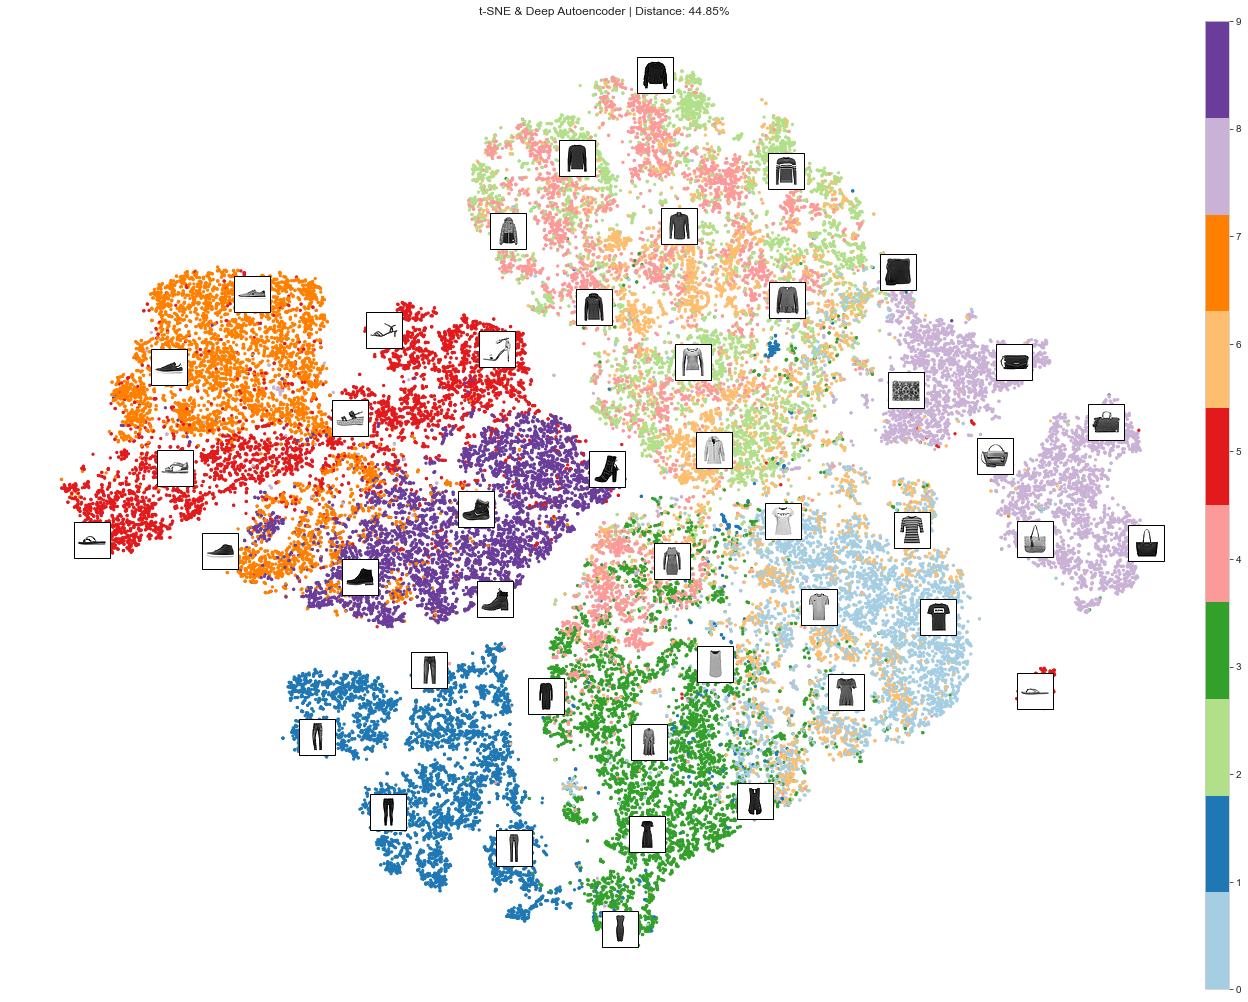

In [115]:
plot_embedding(X=train_embed, title='t-SNE & Deep Autoencoder') # 10 classes